In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Feb 11 18:35:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 39%   65C    P2             205W / 450W |  15756MiB / 24564MiB |     52%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.989501953125
encoder.convs 5.989013671875
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.11-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 87344
-rw-rw-r-- 1 scpark scpark  1085016  2월 11 18:35 events.out.tfevents.1707643380.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 44174932  2월 11 18:34 save_10000
-rw-rw-r-- 1 scpark scpark 44169068  2월 11 18:23 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


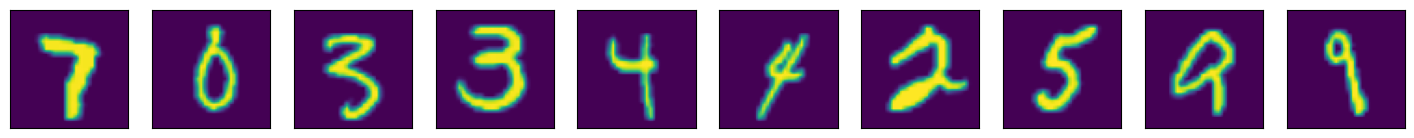

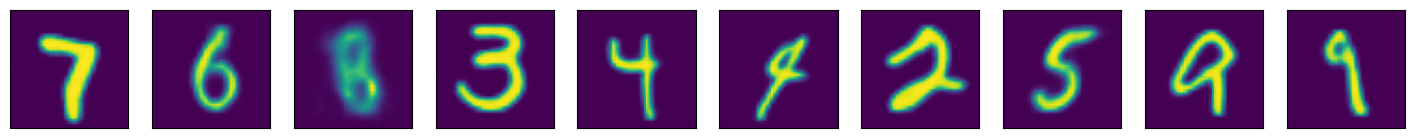

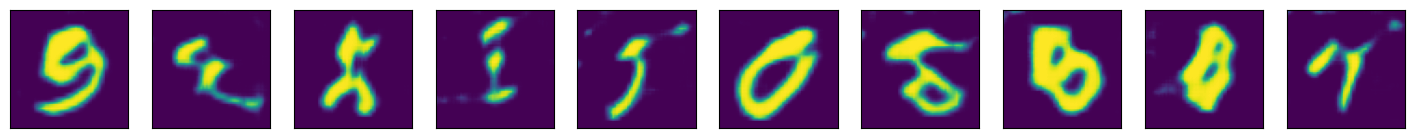

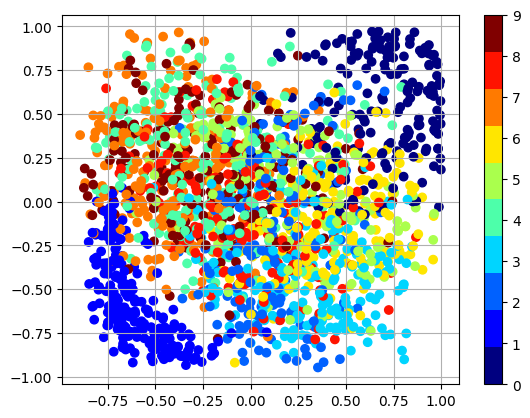

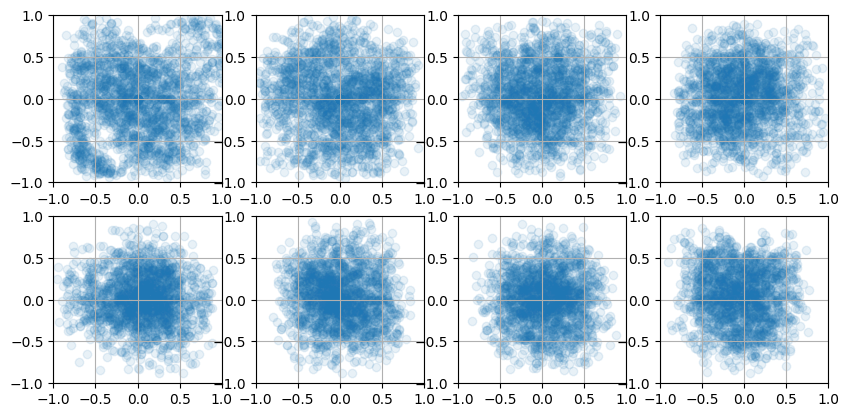

10001
swae_loss 0.009757330641150475
recon_loss 0.0201072059571743
10002
swae_loss 0.010518232360482216
recon_loss 0.01544545590877533
10003
swae_loss 0.010926065035164356
recon_loss 0.02161840908229351
10004
swae_loss 0.010063364170491695
recon_loss 0.018584266304969788
10005
swae_loss 0.010374180041253567
recon_loss 0.022400908172130585
10006
swae_loss 0.011297380551695824
recon_loss 0.022619357332587242
10007
swae_loss 0.011126162484288216
recon_loss 0.016709398478269577
10008
swae_loss 0.009857290424406528
recon_loss 0.02086135372519493
10009
swae_loss 0.008820693008601665
recon_loss 0.013921178877353668
10010
swae_loss 0.01090363971889019
recon_loss 0.019351860508322716
10011
swae_loss 0.009209568612277508
recon_loss 0.021239718422293663
10012
swae_loss 0.010051245801150799
recon_loss 0.016080668196082115
10013
swae_loss 0.009833026677370071
recon_loss 0.015089582651853561
10014
swae_loss 0.010941684246063232
recon_loss 0.018266547471284866
10015
swae_loss 0.01005938183516264
reco

10121
swae_loss 0.011308161541819572
recon_loss 0.01751800626516342
10122
swae_loss 0.009660433977842331
recon_loss 0.015941573306918144
10123
swae_loss 0.010765711776912212
recon_loss 0.017661336809396744
10124
swae_loss 0.013753284700214863
recon_loss 0.020877491682767868
10125
swae_loss 0.011393166147172451
recon_loss 0.017417605966329575
10126
swae_loss 0.010143706575036049
recon_loss 0.014815116301178932
10127
swae_loss 0.010249793529510498
recon_loss 0.02148563787341118
10128
swae_loss 0.009956881403923035
recon_loss 0.022144969552755356
10129
swae_loss 0.010706773027777672
recon_loss 0.017581753432750702
10130
swae_loss 0.01178598590195179
recon_loss 0.019807342439889908
10131
swae_loss 0.010189210996031761
recon_loss 0.020132917910814285
10132
swae_loss 0.0113116055727005
recon_loss 0.018676910549402237
10133
swae_loss 0.010141062550246716
recon_loss 0.016890589147806168
10134
swae_loss 0.010661906562745571
recon_loss 0.01789744943380356
10135
swae_loss 0.011208544485270977
rec

10242
swae_loss 0.00914924405515194
recon_loss 0.015786973759531975
10243
swae_loss 0.011067936196923256
recon_loss 0.018266616389155388
10244
swae_loss 0.01099436730146408
recon_loss 0.017380667850375175
10245
swae_loss 0.011241216212511063
recon_loss 0.01712634786963463
10246
swae_loss 0.012001175433397293
recon_loss 0.018539031967520714
10247
swae_loss 0.012573408894240856
recon_loss 0.01823411136865616
10248
swae_loss 0.010317100211977959
recon_loss 0.017970576882362366
10249
swae_loss 0.010104411281645298
recon_loss 0.019461095333099365
10250
swae_loss 0.010566788725554943
recon_loss 0.019650861620903015
10251
swae_loss 0.010900354012846947
recon_loss 0.017587225884199142
10252
swae_loss 0.010329071432352066
recon_loss 0.01766061596572399
10253
swae_loss 0.009232107549905777
recon_loss 0.023533761501312256
10254
swae_loss 0.011715629138052464
recon_loss 0.016843847930431366
10255
swae_loss 0.010925600305199623
recon_loss 0.017365477979183197
10256
swae_loss 0.012737543322145939
re

10362
swae_loss 0.009754681028425694
recon_loss 0.018279751762747765
10363
swae_loss 0.010874294675886631
recon_loss 0.01567215286195278
10364
swae_loss 0.01082561444491148
recon_loss 0.01740245521068573
10365
swae_loss 0.010365180671215057
recon_loss 0.01697513461112976
10366
swae_loss 0.01118342112749815
recon_loss 0.021426266059279442
10367
swae_loss 0.009794955141842365
recon_loss 0.019470125436782837
10368
swae_loss 0.011969060637056828
recon_loss 0.017224572598934174
10369
swae_loss 0.009834742173552513
recon_loss 0.017049185931682587
10370
swae_loss 0.011679036542773247
recon_loss 0.018632935360074043
10371
swae_loss 0.009638795629143715
recon_loss 0.02116115391254425
10372
swae_loss 0.010348537005484104
recon_loss 0.019310498610138893
10373
swae_loss 0.009278615936636925
recon_loss 0.02168223075568676
10374
swae_loss 0.009610147215425968
recon_loss 0.013986962847411633
10375
swae_loss 0.012181434780359268
recon_loss 0.016537826508283615
10376
swae_loss 0.008735219947993755
reco

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe77816e3f0>>
Traceback (most recent call last):
  File "/home/scpark/anaconda3/envs/ste/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()